## Motivação de estudo

A abordagem de **descida de gradiente estocástica com kernels** tem várias vantagens, incluindo:
- **Eficiência computacional**: É mais eficiente que a descida de gradiente completa, especialmente para grandes volumes de dados.
- **Capacidade online**: O modelo pode ser atualizado conforme novos dados chegam, sem precisar de uma retrain completa.
- **Flexibilidade de kernels**: Permite o uso de diferentes funções de kernel (como polinomiais ou Gaussianas) para ajustar relações não-lineares nos dados.

Esses cálculos formam a base para algoritmos eficientes de regressão online em espaços de alta dimensionalidade.

## Descida de Gradiente Estocástica com Kernels Conceitos Matematicos

O problema inicial que se deseja resolver é o da **regressão ridge com kernels**. A função de custo a ser minimizada é:

$$
J = \|y - \phi(X)\phi(w)\|^2 + c\|\phi(w)\|^2
$$

- $y$ são os valores reais (observados).
- $\phi(X)$ é a transformação dos dados de entrada $X$ em um espaço de dimensão superior, realizada por uma função de kernel.
- $\phi(w)$ são os pesos do modelo.
- $c$ é o parâmetro de regularização que ajuda a evitar overfitting, penalizando valores grandes dos pesos $w$.

A regularização ridge faz com que o modelo não se ajuste excessivamente aos dados de treino, permitindo melhor generalização.

### Descida de Gradiente Estocástica (SGD) com Kernels

A **descida de gradiente** é uma técnica de otimização iterativa, e na sua forma estocástica (SGD), o ajuste dos parâmetros do modelo é feito a cada nova observação de dado, o que reduz os custos computacionais comparados à descida de gradiente tradicional, que usaria todo o conjunto de dados a cada iteração.

O **passo de descida de gradiente** para ajustar os pesos $w$ do modelo é dado pela fórmula:

$$
\phi(w) \leftarrow \phi(w) - \eta \frac{1}{2} \frac{\partial J}{\partial \phi(w)}
$$

Aqui:
- $\eta$ é a **taxa de aprendizado** (um valor pequeno que controla o tamanho do passo).
- $\frac{\partial J}{\partial \phi(w)}$ é o gradiente da função de custo em relação aos pesos $w$, que nos indica a direção da maior inclinação da função de custo.

### Estimativa Instantânea do Gradiente

Como estamos lidando com SGD, usamos uma **estimativa instantânea** do gradiente (baseada apenas no dado atual $x_n$ e sua resposta $y_n$) em vez de calcular o gradiente completo sobre todo o conjunto de dados.

Ao calcular a derivada parcial da função de custo, e ignorando momentaneamente a regularização $c$, a regra de atualização do peso $w$ fica assim:



$$
\phi(w_n) = \phi(w_{n-1}) + \eta \left( y_n \phi(x_n) - \phi(x_n) \phi(w_{n-1})^T \phi(x_n) \right)
$$

Este é o passo de ajuste para o peso $w$ no instante $n$. 

- A expressão $y_n \phi(x_n)$ está associada ao erro entre o valor predito pelo modelo e o valor verdadeiro.
- O termo $\phi(x_n) \phi(w_{n-1})^T \phi(x_n)$ representa a previsão feita pelo modelo com base no dado anterior.

Isso pode ser simplificado com o uso do erro instantâneo $e_n$:

$$
e_n = y_n - \phi(x_n)^T \phi(w_{n-1})
$$

Então, a regra de atualização torna-se:

$$
\phi(w_n) = \phi(w_{n-1}) + \eta e_n \phi(x_n)
$$

Ao confiar no Teorema do Representante, $\varphi(w_n)$ e $\varphi(w_{n-1})$ são expressos como combinações lineares dos dados transformados, resultando em:

$$
\sum_{i=1}^{n} \alpha_n(i) \varphi(x_i) = \sum_{i=1}^{n-1} \alpha_{n-1}(i) \varphi(x_i) + \eta e_n \varphi(x_n)
$$

onde $\alpha_n(i)$ denota o i-ésimo elemento do vetor $\alpha_n$. Se a regularização não for omitida, a regra de atualização fica:

$$
\sum_{i=1}^{n} \alpha_n(i) \varphi(x_i) = (1 - \eta c) \sum_{i=1}^{n-1} \alpha_{n-1}(i) \varphi(x_i) + \eta e_n \varphi(x_n).\tag{1}
$$

O Algoritmo de Minimização de Risco Regularizado Online (NORMA) é uma família de algoritmos estocásticos baseados em gradiente online e kernel . Ele inclui regularização e, portanto, utiliza a Eq. () como sua atualização básica. Vamos focar em sua forma padrão para regressão com uma função de perda quadrática. Concentrando toda a novidade nos novos coeficientes $\alpha_n$, a atualização para o NORMA no passo de tempo $n$ é dada por:

$$
\alpha_n = (1 - \eta c) \alpha_{n-1} + \eta e_n
, \tag{2}
$$

Note que os coeficientes diminuem à medida que $n$ cresce. Portanto, após um certo número de iterações, o coeficiente mais antigo pode ser descartado sem afetar a qualidade da solução. Assim, um mecanismo de dicionário de janela deslizante é obtido, o que impede que a representação funcional cresça de forma excessiva durante a operação online.



# Aplicação do algoritmo

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from timeseriesmetrics import *

models_label = []
models_MAPE = []
models_MAE = []
models_R2 = []
models_theil = []


def computeAccuracyModels(models, y_pred,y_true):
    # Agora iteramos sobre o nome dos modelos
    models_label.append(models)
    
    # Previsões extraídas da coluna especificada no DataFrame
    y_pred = y_pred.values  # Pegando a coluna de previsões
    
    # Tratamento de NaN: Remover os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred
    y_true_clean = y_true.values.ravel() 

    
    # Cálculo das métricas de erro usando os valores sem os primeiros dois NaN
    models_MAE.append(mean_absolute_error(y_true=y_true_clean, y_pred=y_pred_clean))
    models_MAPE.append(mean_absolute_percentage_error(y_true=y_true_clean, y_pred=y_pred_clean))
    models_R2.append(r2_score(y_true=y_true_clean, y_pred=y_pred_clean))
    models_theil.append(theil(y_true_clean,y_pred))

    # Criação do DataFrame com os resultados
    df = pd.DataFrame({
        'model': models_label, 
        'MAE': models_MAE,
        'MAPE': models_MAPE,
        'R2': models_R2,
        'theil': models_theil
    })
    
    print(" --------------------------- Medidas de Erro para os Modelos  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [12]:
dados = pd.read_csv("data_group/ca.csv")

C:\Users\kaio\AppData\Local\Temp\ipykernel_17260\3781233984.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("data_group/ca.csv")


In [13]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [14]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            605
Complemento        579320
Bairro               1176
Valor de Compra    740945
dtype: int64


In [15]:
dados['Estado - Sigla'].value_counts()

Estado - Sigla
BA    240700
CE    159862
PE    132842
MA     77758
RN     54326
PB     52367
PI     51767
AL     47837
SE     34418
Name: count, dtype: int64

## Pre-Processamento

In [16]:
print("tamanho dos dados antes do pre-processamento:",len(dados))
dados.head(5)


tamanho dos dados antes do pre-processamento: 851877


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,GASOLINA,02/01/2019,"4,49",NaN,R$ / litro,BRANCA
1,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,ETANOL,02/01/2019,"3,33",NaN,R$ / litro,BRANCA
2,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,"3,3",NaN,R$ / litro,BRANCA
3,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,"3,4",NaN,R$ / litro,BRANCA
4,NE,AL,ARAPIRACA,POSTO ARAPIRACA LTDA,12.451.076/0001-12,RUA EXPEDICIONARIOS BRASILEIROS,252,NaN,CENTRO,57300-590,GASOLINA,02/01/2019,"4,699","3,8906",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


In [17]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
dados = dados[dados['Estado - Sigla'] == 'RN']
dados = dados[dados['Municipio'] == 'NATAL']

dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])

dados.head()


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,Nome da Rua,Bairro,Cep,Produto,Valor de Venda,Unidade de Medida,Bandeira,Ano,Mes
Data da Coleta,,,,,,,,,,,,,
2019-01-02,NE,RN,NATAL,LUIZ FLOR & FILHOS LTDA,AVENIDA PRUDENTE DE MORAIS,LAGOA NOVA,59063-200,GASOLINA,4.239,R$ / litro,RAIZEN,2019.0,1.0
2019-01-02,NE,RN,NATAL,JVC COMERCIAL LTDA,AVENIDA INDUSTRIAL JOAO FRANCISCO DA MOTTA,FELIPE CAMARAO,59072-480,GASOLINA,4.139,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2019.0,1.0
2019-01-02,NE,RN,NATAL,MENDES PETROLEO LTDA,AVENIDA PRUDENTE DE MORAIS,LAGOA NOVA,59063-200,GASOLINA,4.240,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,RN,NATAL,POSTO CAMPO BELO LTDA,AVENIDA CAPITAO MOR GOUVEIA,BOM PASTOR,59054-170,GASOLINA,4.150,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,RN,NATAL,NATAL COMBUSTÍVEIS LTDA.,AVENIDA SENADOR SALGADO FILHO,LAGOA NOVA,59064-000,GASOLINA,4.240,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2019.0,1.0


In [18]:
# Manter apenas as colunas 'Municipio' e 'Valor de Venda'
dados = dados[['Municipio', 'Valor de Venda']]
print(len(dados))

# Filtrar os dados para incluir apenas os municípios de Crato, Juazeiro e Barbalha
#municipios_desejados = ['MARACANAU', 'FORTALEZA','CAUCAIA']
# dados = dados[dados['Municipio'].isin(municipios_desejados)]

# Reamostrar os dados semanalmente, alinhando as datas ao início do intervalo
dados = dados.groupby('Municipio').resample('W-MON', label='left').mean()

# Preencher os valores NaN com o valor anterior para evitar perda de dados
dados = dados.groupby('Municipio').fillna(method='ffill')

# Resetar o índice e reconfigurar a 'Data da Coleta' como índice
dados = dados.reset_index()
dados.set_index('Data da Coleta', inplace=True)

# Ordenar os dados pelo índice
dados = dados.sort_index()

# Adicionar as colunas 'Ano' e 'Mes'
dados['Ano'] = dados.index.year.astype(float)
dados['Mes'] = dados.index.month.astype(float)


5989


C:\Users\kaio\AppData\Local\Temp\ipykernel_17260\2496079767.py:13: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')
C:\Users\kaio\AppData\Local\Temp\ipykernel_17260\2496079767.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')


In [19]:
dados['Municipio'].value_counts()

Municipio
NATAL    261
Name: count, dtype: int64

In [20]:
print("tamanho dos dados após pre-processamento:",len(dados))
dados.head(5)

tamanho dos dados após pre-processamento: 261


,Municipio,Valor de Venda,Ano,Mes
Data da Coleta,,,,
2018-12-31,NATAL,4.193034,2018.0,12.0
2019-01-07,NATAL,4.161897,2019.0,1.0
2019-01-14,NATAL,4.091111,2019.0,1.0
2019-01-21,NATAL,4.084370,2019.0,1.0
2019-01-28,NATAL,4.110552,2019.0,1.0


In [21]:
dados.to_csv('Natal_week.csv', index=True)


In [12]:
from sklearn.pipeline import Pipeline

# Definindo as colunas numéricas
numeric_features = ['Ano', 'Mes', 'Valor de Venda']

# Separando as features e o target
X = dados[numeric_features]
y = dados['Valor de Venda']

# Criando o pipeline sem o pré-processamento categórico
pipeline = Pipeline(steps=[
    ('passthrough', 'passthrough')  # Nenhum pré-processamento necessário
])

# Aplicando o pipeline aos dados de treino e transformando
X_transformed = pipeline.fit_transform(X)

# Convertendo a matriz para DataFrame mantendo os índices originais
X_transformed_df = pd.DataFrame(X_transformed, 
                                columns=numeric_features,
                                index=X.index)


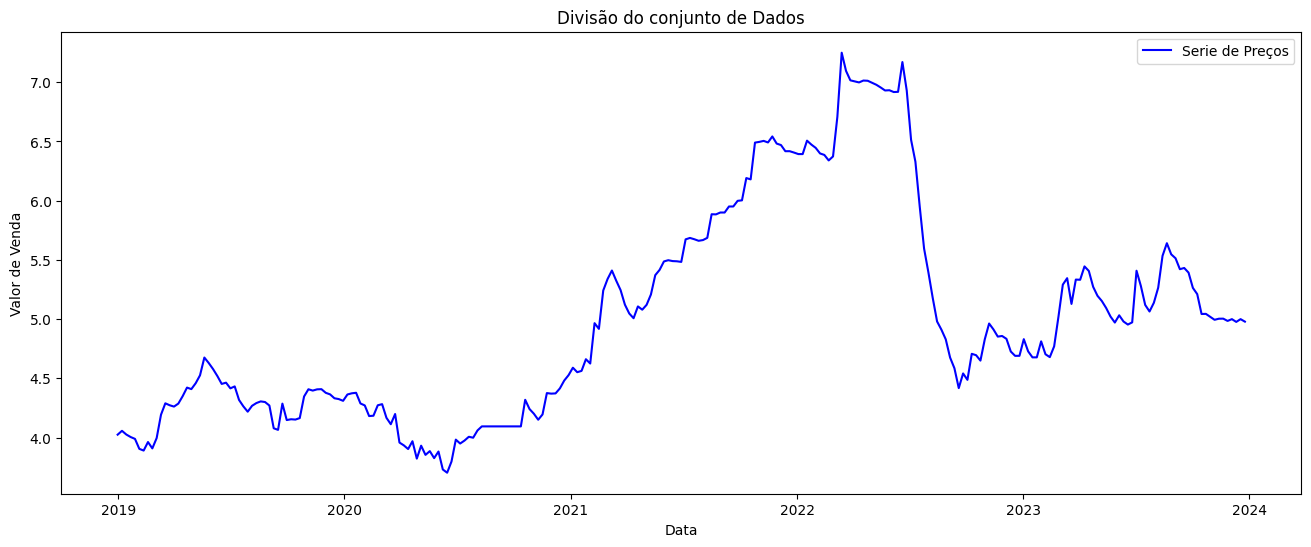

In [13]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y,label='Serie de Preços', color='blue')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

# Plota mais uma vez a serie com um ponto a mais  ou em validação ou em treinamento
# colocar linha vertical pra distinguir teste e validação

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

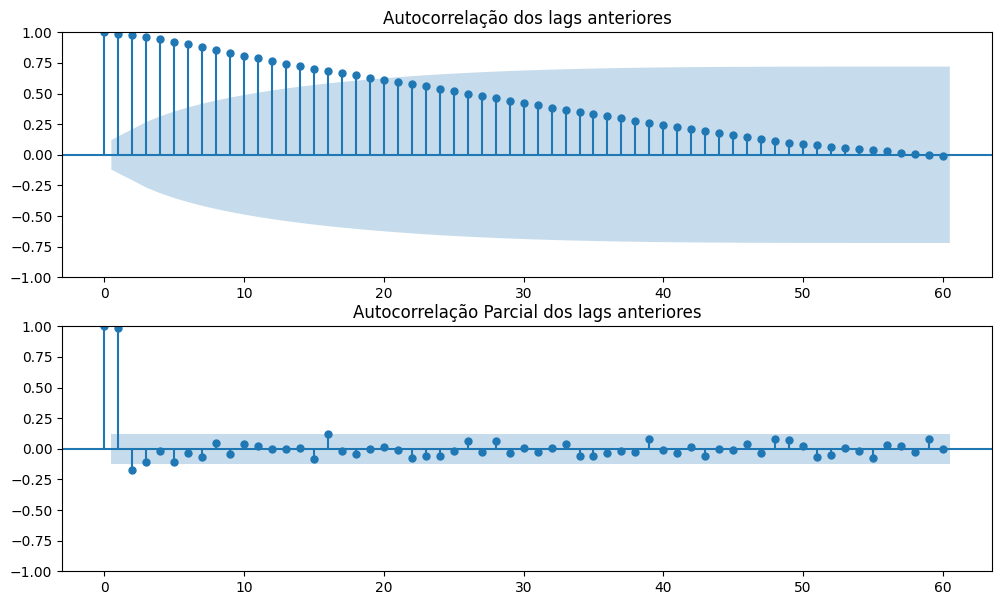

In [14]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X['Valor de Venda'], lags=60, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X['Valor de Venda'], lags=60, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show


Lags Significantes: [1, 2, 3, 5, 15, 16, 22, 26, 28, 34, 39]


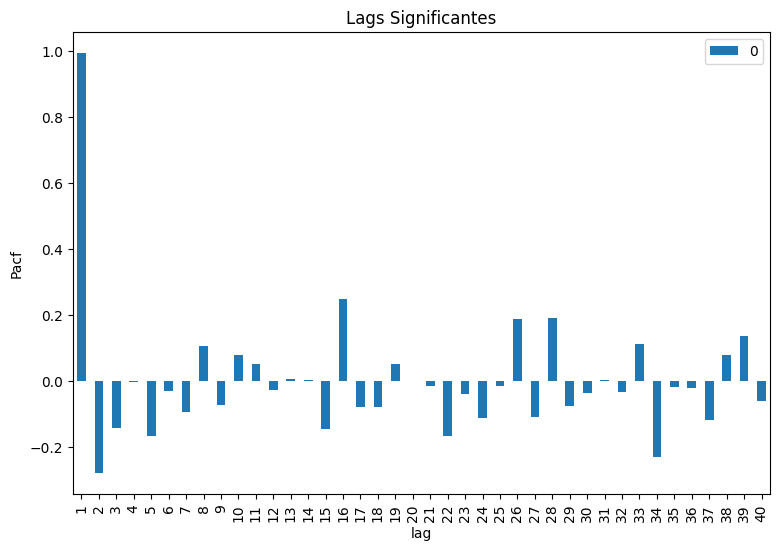

In [15]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 40, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Modelagem

In [16]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    x = df[y]

    # Se houver dados anteriores (ex.: dados de treino para preencher lags na validação)
    if previousData is not None:
        x = pd.concat([previousData[y], x])
    
    # Criando as variáveis de lag
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag).iloc[len(previousData) if previousData is not None else 0:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df


# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
# Geração das variáveis de lag para o treino
X_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_transformed_df, 
    dropna=True
)

# Separando a variável alvo do treino, validação e teste
y_true = X_transformed_df['Valor de Venda']

# Removendo a coluna de 'Valor de Venda' dos conjuntos de treino, validação e teste
X_transformed_df = X_transformed_df.drop(columns=['Valor de Venda'])


In [17]:

X_transformed_df.head()

,Ano,Mes,Valor de Venda-1),Valor de Venda-2),Valor de Venda-3),Valor de Venda-5),Valor de Venda-15),Valor de Venda-16),Valor de Venda-22),Valor de Venda-26),Valor de Venda-28),Valor de Venda-34),Valor de Venda-39)
Data da Coleta,,,,,,,,,,,,,
2019-09-30,2019.0,9.0,4.286800,4.065275,4.078569,4.300154,4.453137,4.519714,4.409278,4.261765,4.289385,3.904870,4.024706
2019-10-07,2019.0,10.0,4.148039,4.286800,4.065275,4.270653,4.463745,4.453137,4.459000,4.287081,4.273000,3.890507,4.057096
2019-10-14,2019.0,10.0,4.154808,4.148039,4.286800,4.078569,4.415706,4.463745,4.525852,4.349732,4.261765,3.962448,4.025840
2019-10-21,2019.0,10.0,4.152082,4.154808,4.148039,4.065275,4.432145,4.415706,4.675818,4.422077,4.287081,3.908804,4.004687
2019-10-28,2019.0,10.0,4.164627,4.152082,4.154808,4.286800,4.317745,4.432145,4.630042,4.409278,4.349732,3.996078,3.989000


## Gradient Descendent Online in ridge regression

Previsões de Random Walk para o conjunto de validação:


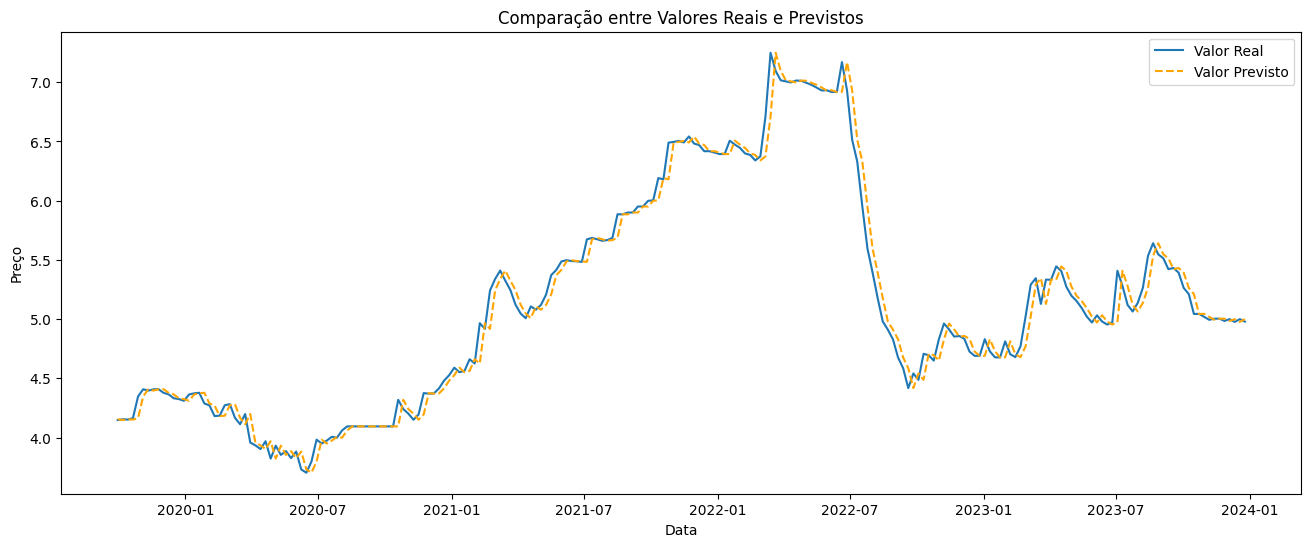

In [18]:
# Combine os dados de treino e validação para formar uma série contínua
X_combined_df = X_transformed_df
y_combined = y_true

# Função de previsão Random Walk para o conjunto de validação
def random_walk_forecast(series):
    # Previsão do Random Walk: a previsão para cada ponto é o valor imediatamente anterior
    return series.shift(1)

# Aplicar a previsão no conjunto combinado
y_forecast = random_walk_forecast(y_true)
y_forecast.iloc[0] = y_true.iloc[1]  # Ajuste o primeiro valor

# Selecionar apenas as previsões para o conjunto de validação
y_forecast = y_forecast.loc[y_true.index]

# Exibir as previsões para o conjunto de validação
print("Previsões de Random Walk para o conjunto de validação:")
plt.figure(figsize=(16, 6))
plt.plot(y_true, label='Valor Real')
plt.plot(y_forecast, label='Valor Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [19]:
computeAccuracyModels(models='Randon Walk', y_pred=y_forecast,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
         model      MAE     MAPE        R2  theil
0  Randon Walk  0.07583  0.01476  0.982722    1.0


In [20]:
from sklearn.preprocessing import StandardScaler

# Calcular resíduos (erro entre a série original e a previsão)
residuos_serie = y_true - y_forecast

# Construir variáveis lagged para previsão
# `X_residual_1` será o resíduo defasado em um ponto
# `X_residual_2` será o resíduo defasado em dois pontos
X_residual_1 = residuos_serie.shift(1)
X_residual_2 = residuos_serie.shift(2)

# Ajustar os valores iniciais ausentes para consistência
X_residual_1.iloc[0] = X_residual_1.iloc[1]  # Ajustar o primeiro valor
X_residual_2.iloc[:2] = X_residual_1.iloc[1]  # Ajustar os dois primeiros valores de X_residual_2

# Concatenar as defasagens em um único DataFrame para escalonamento
X_residual = pd.concat([X_residual_1, X_residual_2], axis=1)
X_residual.columns = ['Lag_1', 'Lag_2']


# Escalar os dados para manter consistência com o modelo anterior
scaler_residual = StandardScaler()
X_residual_scaled = scaler_residual.fit_transform(X_residual.values)

y_residual = residuos_serie.loc[X_residual.index]



In [21]:
print("residuos forecast",len(y_forecast))
print("residuos",len(y_true))


y_residual_1 = residuos_serie.shift(1)

# Ajustar os valores iniciais ausentes para consistência
y_residual_1.iloc[0] = y_residual_1.iloc[1]  # Ajustar o primeiro valor


residuos forecast 222
residuos 222


In [22]:
print(len(X_residual))
print(len(y_residual))

222
222


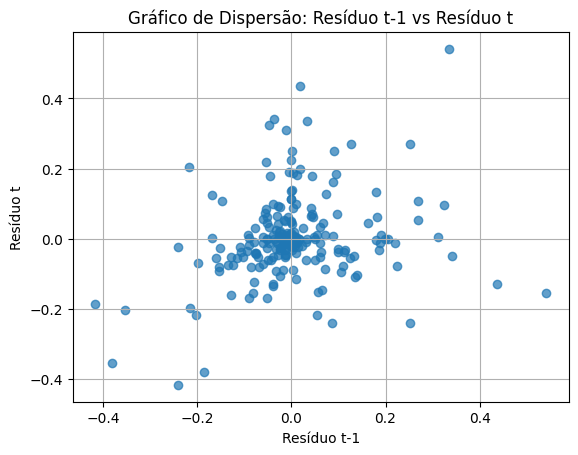

In [23]:
plt.scatter(y_residual_1,y_residual, alpha=0.7)
plt.title("Gráfico de Dispersão: Resíduo t-1 vs Resíduo t")
plt.xlabel("Resíduo t-1")
plt.ylabel("Resíduo t")
plt.grid(True)
plt.show()

# usar regressão linear pra prever os residuos

In [24]:
'''df = pd.DataFrame(
    {
         'valor dos residuos': residuos_serie,
         'residuos com lag(1)':X_residual
    }
)'''

"df = pd.DataFrame(\n    {\n         'valor dos residuos': residuos_serie,\n         'residuos com lag(1)':X_residual\n    }\n)"

In [25]:
'''df.corr()'''

'df.corr()'

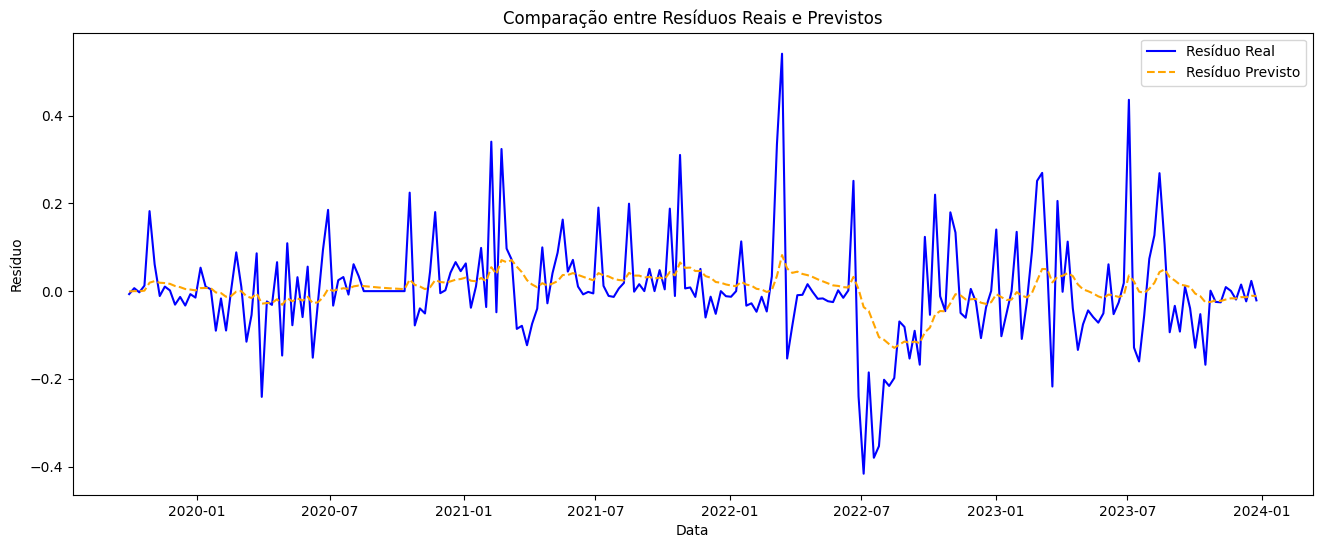

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from norm import RidgeSGDKernelTorchDict

# Supondo que seus dados residuais estejam em `y_residual` e `X_residual`
# Converter os dados em dicionários para serem compatíveis com o modelo, utilizando o índice de `y_residual`
X_residual_dict = {idx: x for idx, x in zip(y_residual.index, X_residual.values)}
y_residual_dict = {idx: y for idx, y in zip(y_residual.index, y_residual.values)}

# Instanciar o modelo com os parâmetros desejados
ridge_sgd_torch = RidgeSGDKernelTorchDict(eta=0.1, c=0.1, sigma=1.0)

# Lista para armazenar previsões
y_pred = {}

# Treinar e prever de forma online com os dados residuais
for idx in X_residual_dict.keys():
    x_new = X_residual_dict[idx]
    y_new = y_residual_dict[idx]

    # Atualizar o modelo com o novo ponto
    ridge_sgd_torch.partial_fit(x_new, y_new, idx)

    # Fazer a previsão
    prediction = ridge_sgd_torch.predict(x_new)
    y_pred[idx] = prediction

# Converter as previsões em um pandas.Series para facilitar o plot
y_pred_series = pd.Series(y_pred).sort_index()
y_residual_series = pd.Series(y_residual_dict).sort_index()

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual_series, label='Resíduo Real', color='blue')
plt.plot(y_pred_series, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()


# 0.020130874319912704

In [27]:
'''
# Obter os melhores parâmetros da busca
best_eta = bayes_search.best_params_['eta']
best_c = bayes_search.best_params_['c']
best_sigma = bayes_search.best_params_['sigma']

# Criar e treinar o modelo com os melhores parâmetros encontrados
ridge_sgd_torch_best = RidgeSGDKernelTorch(eta=best_eta, c=best_c, sigma=best_sigma)

# Lista para armazenar previsões
y_pred_best = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_best.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_best.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_best.append(prediction)

# Previsões indexadas para facilitar o plot
y_pred_bayes_indexed = pd.Series(y_pred_best, index=y_residual.index)

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real', color='blue')
plt.plot(y_pred_bayes_indexed, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos com Parâmetros Otimizados')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()
'''


"\n# Obter os melhores parâmetros da busca\nbest_eta = bayes_search.best_params_['eta']\nbest_c = bayes_search.best_params_['c']\nbest_sigma = bayes_search.best_params_['sigma']\n\n# Criar e treinar o modelo com os melhores parâmetros encontrados\nridge_sgd_torch_best = RidgeSGDKernelTorch(eta=best_eta, c=best_c, sigma=best_sigma)\n\n# Lista para armazenar previsões\ny_pred_best = []\n\n# Treinar e prever de forma online com os dados residuais\nfor x_new, y_new in zip(X_residual.values, y_residual.values):\n    ridge_sgd_torch_best.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto\n    prediction = ridge_sgd_torch_best.predict(x_new)  # Faz a previsão imediatamente após o ajuste\n    y_pred_best.append(prediction)\n\n# Previsões indexadas para facilitar o plot\ny_pred_bayes_indexed = pd.Series(y_pred_best, index=y_residual.index)\n\n# Visualizar os resultados\nplt.figure(figsize=(16, 6))\nplt.plot(y_residual, label='Resíduo Real', color='blue')\nplt.plot(y_pred_bayes_inde

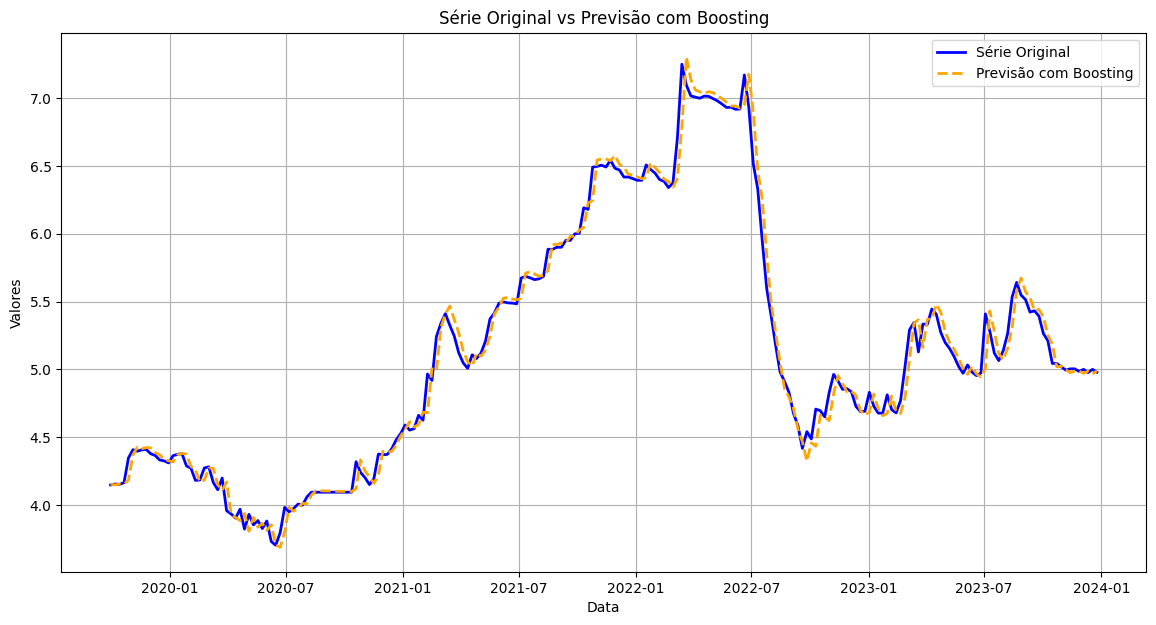

In [28]:
import matplotlib.pyplot as plt

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_bayes = y_forecast + y_pred_series

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_pred_series.index, y_boosted_forecast_bayes, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()


In [29]:

computeAccuracyModels(models='Boosting with bayes-NORMA', y_pred=y_boosted_forecast_bayes,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1  Boosting with bayes-NORMA  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000


Previsões para os resíduos: [0.0, -0.0027073908131569624, 0.0018932449165731668, -0.0005194961559027433, 0.004849704913794994, 0.06319278478622437, 0.042943309992551804, 0.018616659566760063, 0.01257418841123581, 0.003857295960187912, -0.010572612285614014, -0.007936857640743256, -0.015635043382644653, -0.007352322340011597, -0.00831144955009222, 0.018154922872781754, 0.009368812665343285, 0.005027433857321739, -0.03226453810930252, -0.016820279881358147, -0.03885216265916824, -0.013877023011446, 0.026974692940711975, 0.011687051504850388, -0.033248353749513626, -0.025825459510087967, 0.016387928277254105, -0.04312123730778694, -0.03991434723138809, -0.03932150825858116, 0.0054354798048734665, -0.02934923581779003, -0.011165745556354523, 0.006063841283321381, -0.010704919695854187, -0.009663507342338562, 0.0012805312871932983, -0.022405914962291718, -0.04196329414844513, 0.010581143200397491, 0.06052602827548981, 0.017171792685985565, 0.025562208145856857, 0.017574574798345566, 0.00368

c:\Users\kaio\OneDrive\Área de Trabalho\Series Temporais\ridge_sgd_kernel.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.X_train_tensor = torch.tensor([x_new], dtype=torch.float32)  # Inicializa o conjunto de treino


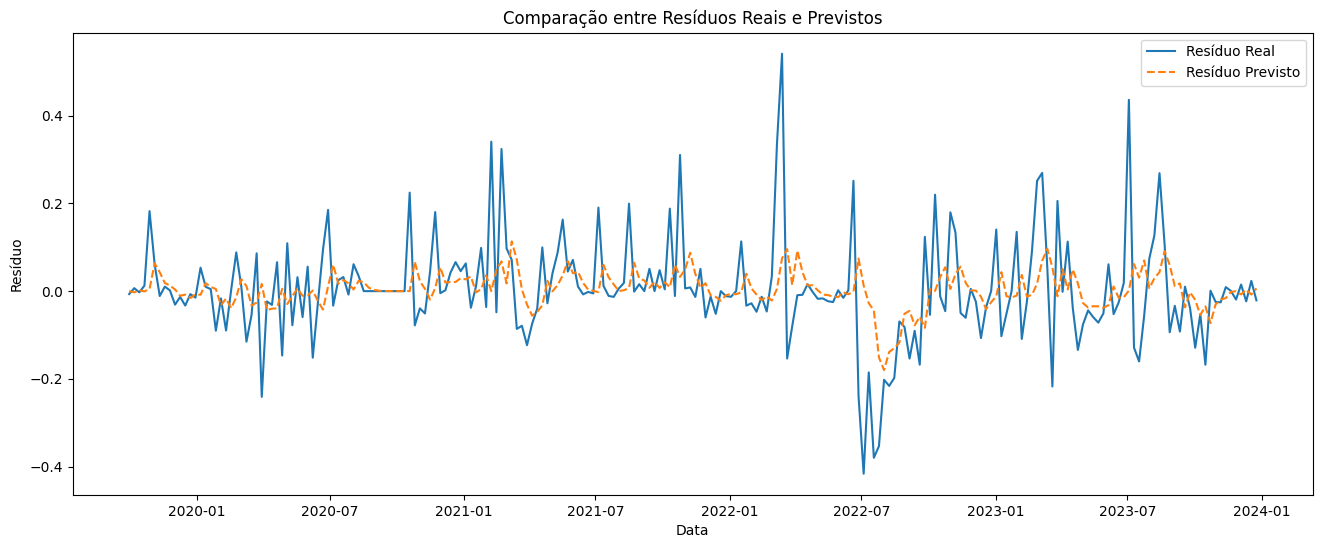

In [30]:
from ridge_sgd_kernel import RidgeSGDKernelTorch, Ridgkernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Criar o modelo para os resíduos
ridge_sgd_torch_residual = RidgeSGDKernelTorch(eta=0.5, c=0.4, sigma=0.3)

# List para armazenar previsões
y_pred_residual = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_residual.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_residual.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_residual.append(prediction)

# Previsões indexadas
y_pred_residual_indexed = pd.Series(y_pred_residual, index=y_residual.index)

# Visualizar os resultados
print("Previsões para os resíduos:", y_pred_residual)
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real')
plt.plot(y_pred_residual_indexed, label='Resíduo Previsto', linestyle='--')
plt.title('Comparação entre Resíduos Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()



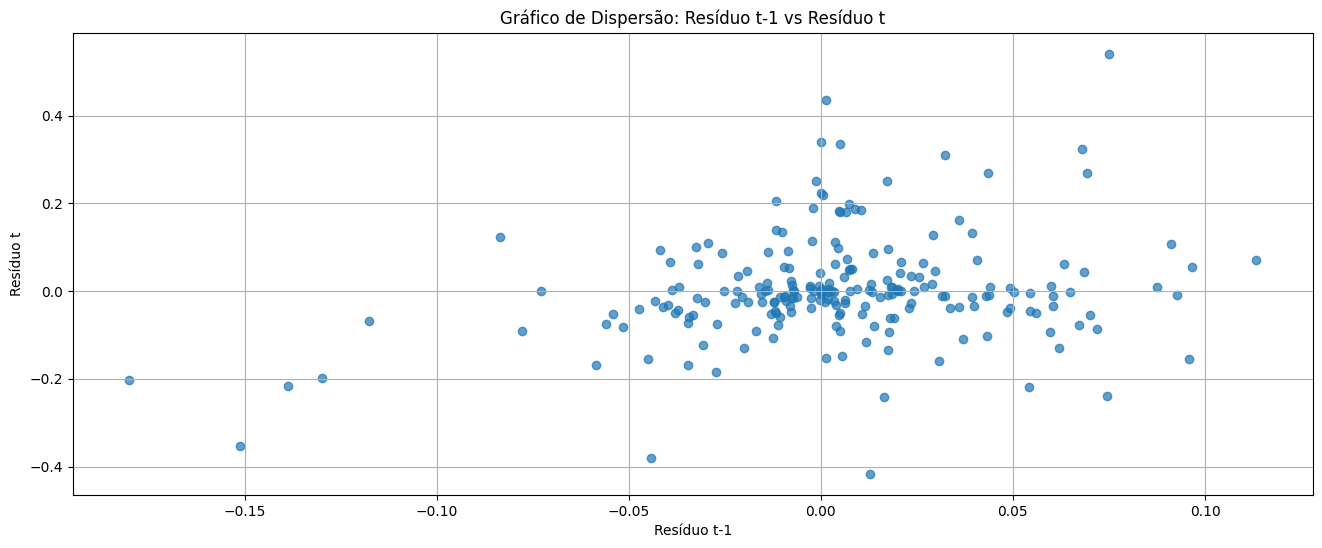

In [31]:
plt.figure(figsize=(16, 6))

plt.scatter(y_pred_residual_indexed,y_residual,alpha=0.7)
plt.title("Gráfico de Dispersão: Resíduo t-1 vs Resíduo t")
plt.xlabel("Resíduo t-1")
plt.ylabel("Resíduo t")
plt.grid(True)
plt.show()

In [32]:
residuals_df = pd.DataFrame({
    'Resíduo Real': y_residual,  # Resíduos reais
    'Resíduo Previsto': y_pred_residual_indexed  # Resíduos previstos
})

# Exibir as primeiras linhas do DataFrame
print(residuals_df.head())


                Resíduo Real  Resíduo Previsto
Data da Coleta                                
2019-09-30         -0.006768          0.000000
2019-10-07          0.006768         -0.002707
2019-10-14         -0.002726          0.001893
2019-10-21          0.012546         -0.000519
2019-10-28          0.182373          0.004850


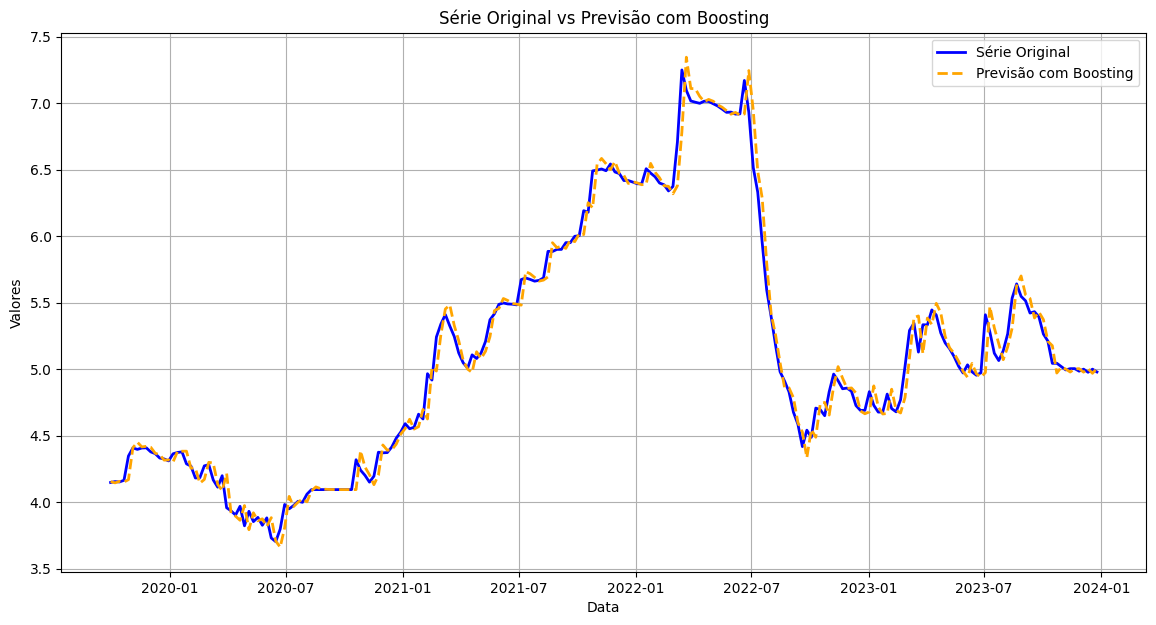

In [33]:
import matplotlib.pyplot as plt

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast = y_forecast + y_pred_residual_indexed

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_boosted_forecast.index, y_boosted_forecast, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
computeAccuracyModels(models='Boosting with GDO-NORMA', y_pred=y_boosted_forecast,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1  Boosting with bayes-NORMA  0.070709  0.013655  0.986304  0.792651
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2    Boosting with GDO-NORMA  0.076694  0.014907  0.983652  0.946172


In [35]:
X_residual

,Lag_1,Lag_2
Data da Coleta,,
2019-09-30,-0.006768,-0.006768
2019-10-07,-0.006768,-0.006768
2019-10-14,0.006768,-0.006768
2019-10-21,-0.002726,0.006768
2019-10-28,0.012546,-0.002726
...,...,...
2023-11-27,0.000482,0.009184
2023-12-04,-0.019167,0.000482
2023-12-11,0.015000,-0.019167


## Arima 

In [36]:
X_residual = X_residual.drop(columns='Lag_2')

In [ ]:
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt

# Separar os resíduos de treino para modelagem
residuos_train = X_residual['Lag_1']

# Ajustar o modelo AutoARIMA
model = pm.auto_arima(residuos_train, seasonal=False, stepwise=True, trace=True)

# Lista para armazenar as previsões iterativas
predictions_online = []

# Prever um ponto de cada vez e ajustar o modelo
for i in range(len(y_residual)):
    # Fazer a previsão do próximo ponto
    prediction = model.predict(n_periods=1)
    
    # Armazenar a previsão
    predictions_online.append(prediction[0])
    
    # Atualizar o modelo com o novo ponto real (adicionar o valor real da série)
    model.update(y_residual.iloc[i])

# Convertendo as previsões para uma série
prediction_series_online = pd.Series(predictions_online, index=y_residual.index)

print(prediction_series_online)

# Plotar os resultados (opcional)
plt.figure(figsize=(16, 6))
plt.plot(y_residual.index, y_residual, label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Online)', linestyle='--')
plt.title('Previsão dos resíduos com AutoARIMA (Online)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()




NameError: name 'X_residual_salvador' is not defined

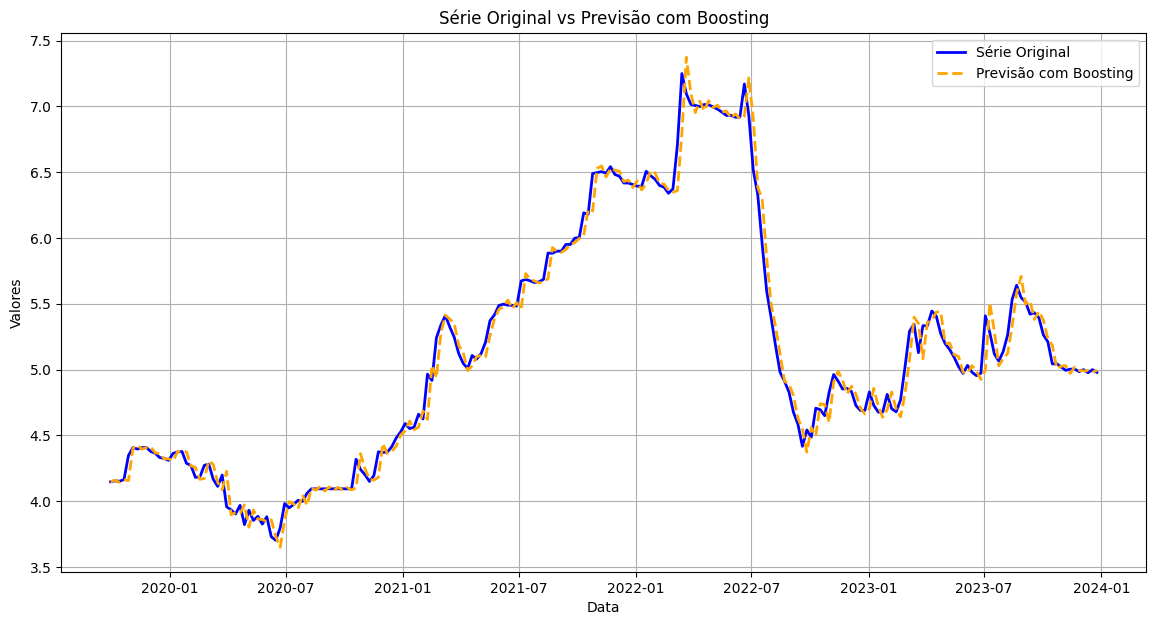

In [38]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_arima = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_arima, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with Arima', y_pred=y_boosted_forecast_arima,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
1  Boosting with bayes-NORMA  0.070709  0.013655  0.986304  0.792651
3        Boosting with Arima  0.074815  0.014585  0.984170  0.916179
0                Randon Walk  0.075830  0.014760  0.982722  1.000000
2    Boosting with GDO-NORMA  0.076694  0.014907  0.983652  0.946172
